# Buirning Rate & Elements Consuming Time (xDays) 

In [1]:
### ***Enviroment Preparation***
# Install Pandas
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm

!pip install dtale

!pip install sktime
!pip install sklego

!pip install rich
#!pip install skforecast

# Update pip -- WARNING Resolution
!python.exe -m pip install --upgrade pip

In [2]:
### ***Imports***
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime
from datetime import timedelta
from datetime import time
from datetime import date

from sklearn.ensemble import IsolationForest

import dtale
from rich.progress import track

# Recopilar Datos

In [3]:
# Paths
data = r"C:\Users\ghoyo\Desktop\TFM 3.0\Project\GeneratedDfs\VisualsData.json"

# Investigar Y Limpiar Datos

In [4]:
df = pd.read_json(data)
df.shape

(82028, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82028 entries, 0 to 82027
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   platform                           82028 non-null  object        
 1   master_metadata_track_name         82028 non-null  object        
 2   master_metadata_album_artist_name  82028 non-null  object        
 3   master_metadata_album_album_name   82028 non-null  object        
 4   spotify_track_uri                  82028 non-null  object        
 5   reason_start                       82028 non-null  object        
 6   reason_end                         82028 non-null  object        
 7   is_song                            82028 non-null  int64         
 8   is_podcast                         82028 non-null  int64         
 9   end_streaming                      82028 non-null  int64         
 10  s_played                          

In [6]:
df.head()

,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,is_song,is_podcast,end_streaming,...,days_to_next_month,date,hour,minute,second,time,str_time,time_in_s,week_day,df_fractured
0,Phone,Excesos,Natos y Waor,Caja Negra,spotify:track:1bp8LR3mPRlHs0dOZGNHm3,fwdbtn,endplay,1,0,1491312576000,...,26,2017-04-04,13,29,36,13:29:36,2023-04-21 13:29:36,48576,1,0
1,Phone,Calavera no chilla,Natos y Waor,Calavera no chilla,spotify:track:5dgA6aIoYJvTz48qAI0rPf,clickrow,logout,1,0,1491314816000,...,26,2017-04-04,14,6,56,14:06:56,2023-04-21 14:06:56,50816,1,0
2,Phone,Metacrilato,Ayax y Prok,Metacrilato,spotify:track:5z5Q95JbFva9DcKnshOgiU,appload,logout,1,0,1491314927000,...,26,2017-04-04,14,8,47,14:08:47,2023-04-21 14:08:47,50927,1,0
3,Phone,Metacrilato,Ayax y Prok,Metacrilato,spotify:track:5z5Q95JbFva9DcKnshOgiU,appload,trackdone,1,0,1491315024000,...,26,2017-04-04,14,10,24,14:10:24,2023-04-21 14:10:24,51024,1,0
4,Phone,La flauta de Hamelin,Ayax y Prok,Albayzín Recopilatorio,spotify:track:1XnG8fGed91t2U061Xb5gZ,clickrow,endplay,1,0,1491315271000,...,26,2017-04-04,14,14,31,14:14:31,2023-04-21 14:14:31,51271,1,0


In [7]:
# Some data transformations
def transform_time(df):
    df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
def transform_date(df):
    df['date'] = df['date'].apply(lambda x: date(x.year, x.month, x.day))

def generate_end_streaming(df):
    transform_time(df)
    #transform_date(df)
    df['end_streaming'] = df.apply(lambda x: rt_dt(x['date'], x['time']), axis=1)


def rt_dt(dfdate, dftime):
    return datetime(dfdate.year, dfdate.month, dfdate.day, dftime.hour, dftime.minute, dftime.second) 

In [8]:
%%time
generate_end_streaming(df)

CPU times: total: 1.41 s
Wall time: 1.95 s


In [9]:
df['end_streaming'].head(2)

0   2017-04-04 13:29:36
1   2017-04-04 14:06:56
Name: end_streaming, dtype: datetime64[ns]

In [10]:
# Generate new usefull column

In [11]:
df['week_and_year'] = df['end_streaming'].apply(lambda x : (x.year, x.week))
df['week_and_year'] = df['week_and_year'].apply(lambda x: '-'.join(map(str, x)))

In [12]:
df['week_and_year'].head(2)

0    2017-14
1    2017-14
Name: week_and_year, dtype: object

In [13]:
dfi = df[['end_streaming', 'master_metadata_track_name', 'is_song', 'week_and_year']]

In [14]:
dfi.drop_duplicates()
dfi.reset_index(inplace=True, drop=True)

In [15]:
dfi.head()

,end_streaming,master_metadata_track_name,is_song,week_and_year
0,2017-04-04 13:29:36,Excesos,1,2017-14
1,2017-04-04 14:06:56,Calavera no chilla,1,2017-14
2,2017-04-04 14:08:47,Metacrilato,1,2017-14
3,2017-04-04 14:10:24,Metacrilato,1,2017-14
4,2017-04-04 14:14:31,La flauta de Hamelin,1,2017-14


#### Get unique Streams list & Dataset of this one

In [16]:
u_stream_list = df['master_metadata_track_name'].unique()
    #drop_df = df.drop_duplicates(subset = ['master_metadata_track_name', 'week_and_year'])
    #print(drop_df['master_metadata_track_name'].value_counts()['Insoportables'])

# Get week Index Lists
u_week_list = df['week_and_year'].unique()
week_list = [df[df['week_and_year'] == w].index for w in u_week_list]

In [17]:
print(len(u_stream_list))
u_stream_list

14082


array(['Excesos', 'Calavera no chilla', 'Metacrilato', ...,
       'somehow she’s still here (feat. James Blake)',
       'WHY AM I STILL IN LA (feat. Shlohmo & D33J)', 'je suis'],
      dtype=object)

In [18]:
print(len(u_week_list))
print(u_week_list[:20]) 
print('...')

297
['2017-14' '2017-15' '2017-16' '2017-17' '2017-18' '2017-19' '2017-20'
 '2017-21' '2017-22' '2017-23' '2017-24' '2017-25' '2017-26' '2017-27'
 '2017-28' '2017-29' '2017-30' '2017-31' '2017-32' '2017-33']
...


In [19]:
print(len(week_list))
print(len(week_list[0]))
print(week_list[1])

week_list_mean = [len(w) for w in week_list]
print(week_list_mean, '\n')

print(np.mean(week_list_mean))

297
389
Int64Index([389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
            402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
            415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427,
            428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
            441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
            454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
            467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479],
           dtype='int64')
[389, 91, 328, 231, 251, 213, 455, 486, 395, 225, 148, 247, 102, 268, 322, 244, 194, 190, 301, 477, 485, 262, 271, 211, 247, 221, 238, 305, 419, 250, 345, 474, 291, 235, 380, 455, 539, 410, 339, 152, 324, 281, 363, 285, 250, 326, 388, 295, 359, 226, 380, 480, 215, 163, 237, 274, 401, 307, 150, 235, 240, 278, 196, 249, 197, 177, 242, 766, 328, 253, 384, 168, 250, 236, 139, 241, 200, 213, 173, 222, 374, 297, 200, 181, 176, 2

In [20]:
%%time

# Generate Result Variables
sec_streamed = []
num_streamed = []
ix_list = []

s_sec_streamed = []
s_num_streamed = []
s_ix_list = []

ix_aux_list = []
sec = 0
num = 0

# loop to get streak of streams during weeks
for s in track(u_stream_list, description='Search for all Streams'):
    for wi in week_list:
        for i in wi:
            if (s == df.loc[i, 'master_metadata_track_name']):
                # Extract full Week Data
                ix_aux_list.append(i)
                sec = sec + df.loc[i, 's_played']
                num = num+1
        
        # Save Single Stream Data
        s_sec_streamed.append(sec)
        s_num_streamed.append(num)
        if(len(ix_aux_list) != 0):
            s_ix_list.append(ix_aux_list)
        
        # Clean Aux Vars
        ix_aux_list = []
        sec = 0
        num = 0
    
    # Save All Streams Stream Data
    sec_streamed.append(s_sec_streamed)
    num_streamed.append(s_num_streamed)
    ix_list.append(s_ix_list)

    # Clean Single Stream Vars
    s_sec_streamed = []
    s_num_streamed = []
    s_ix_list = []

Output()

CPU times: total: 52min 23s
Wall time: 2h 18min 51s


In [21]:
#sec_streamed
#ix_list
n_weeks = len(num_streamed[0])
print(n_weeks)
num_streamed[-1][n_weeks-1]

# N Streams 
n_streams = len(df['master_metadata_track_name'].unique())
print(n_streams)
stream_list = df['master_metadata_track_name'].unique()



297
14082


In [22]:
# Create Dataframe
num_df = pd.DataFrame(index = df['master_metadata_track_name'].unique())
num_df

""
Excesos
Calavera no chilla
Metacrilato
La flauta de Hamelin
2000 Clavos
...
Need4Speed - Fumado y Hambriento
HOODS HOTTEST
somehow she’s still here (feat. James Blake)
WHY AM I STILL IN LA (feat. Shlohmo & D33J)


In [23]:
# Create Columns:
cols = []
for w,i in zip(num_streamed[0], range(n_weeks)):
     cols.append(''.join(('w',str(i))))

num_df[cols] = np.nan

# Insert info at each column
for s,i in track(zip(num_streamed, range(n_streams)), description='Completing Dataset'):
    for w,c in zip(s, cols):
        num_df.loc[stream_list[i], c] = w

num_df.head()

Output()

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_14500\1378283885.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_14500\1378283885.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_14500\1378283885.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w287,w288,w289,w290,w291,w292,w293,w294,w295,w296
Excesos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Calavera no chilla,25.0,4.0,36.0,17.0,8.0,2.0,4.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metacrilato,40.0,3.0,39.0,26.0,13.0,4.0,4.0,8.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
La flauta de Hamelin,3.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000 Clavos,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
num_df.tail()

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w287,w288,w289,w290,w291,w292,w293,w294,w295,w296
Need4Speed - Fumado y Hambriento,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
HOODS HOTTEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
somehow she’s still here (feat. James Blake),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
WHY AM I STILL IN LA (feat. Shlohmo & D33J),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
je suis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [25]:
l = len(num_df.columns)-1
print(l)

296


In [26]:
# Ignorar semanas con 0 si es Semana donde se escucha por primera vez
first_flag = 0
last_flag = 0

num_df['first_listened'] = np.nan
num_df['last_listened'] = np.nan

# First Listened
for s in stream_list:
    for w,i in zip(num_df.columns[:-2], range(n_weeks)):
        if(i == 0 and num_df.loc[s, w] == 0):
            first_flag = 0
        
        elif(i != 0 and num_df.loc[s, w] == 0 and first_flag == 0):
            first_flag = 0
        
        elif(i != 0 and num_df.loc[s, w] != 0):
            num_df.loc[s, 'first_listened'] = i
            break
        
        elif(i == 0 and num_df.loc[s,w] != 0):
            num_df.loc[s, 'first_listened'] = i
            break
        
        elif(w == num_df.columns[:-2][-1]):
            num_df.loc[s, 'first_listened'] = i

# Last Listened
# Reverse Dataset
rev_n_df = num_df.iloc[:, ::-1]

for s in stream_list:
    for w,i in zip(rev_n_df.columns[2:], range(n_weeks)):
        if(i == 0 and rev_n_df.loc[s, w] == 0):
            last_flag = 0
        
        elif(i != 0 and rev_n_df.loc[s, w] == 0 and last_flag == 0):
            last_flag = 0
        
        elif(i != 0 and rev_n_df.loc[s, w] != 0):
            num_df.loc[s, 'last_listened'] = n_weeks-i
            break
        
        elif(i == 0 and rev_n_df.loc[s,w] != 0):
            num_df.loc[s, 'last_listened'] = n_weeks-i
            break
        
        elif(w == rev_n_df.columns[2:][-1]):
            num_df.loc[s, 'last_listened'] = n_weeks-i

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_14500\2493253983.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ghoyo\AppData\Local\Temp\ipykernel_14500\2493253983.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [27]:
rev_n_df.columns

Index(['last_listened', 'first_listened', 'w296', 'w295', 'w294', 'w293',
       'w292', 'w291', 'w290', 'w289',
       ...
       'w9', 'w8', 'w7', 'w6', 'w5', 'w4', 'w3', 'w2', 'w1', 'w0'],
      dtype='object', length=299)

In [28]:
num_df[['first_listened', 'last_listened']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14082 entries, Excesos to je suis
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_listened  14082 non-null  float64
 1   last_listened   14082 non-null  float64
dtypes: float64(2)
memory usage: 846.1+ KB


In [29]:
num_df

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w289,w290,w291,w292,w293,w294,w295,w296,first_listened,last_listened
Excesos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Calavera no chilla,25.0,4.0,36.0,17.0,8.0,2.0,4.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0
Metacrilato,40.0,3.0,39.0,26.0,13.0,4.0,4.0,8.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0
La flauta de Hamelin,3.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0
2000 Clavos,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Need4Speed - Fumado y Hambriento,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,296.0,297.0
HOODS HOTTEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,296.0,297.0
somehow she’s still here (feat. James Blake),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,296.0,297.0
WHY AM I STILL IN LA (feat. Shlohmo & D33J),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,296.0,297.0


In [30]:
#num_df['streak_list'] = np.nan
#num_df.loc['RAPSTAR','streak_list'] = 0

<AxesSubplot: >

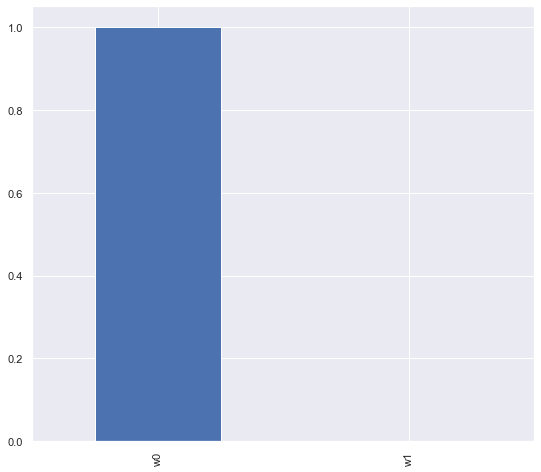

In [31]:
stream = 0
start = int(num_df.loc[stream_list[stream],'first_listened'])
end = int(num_df.loc[stream_list[stream],'last_listened'])
num_df.loc[stream_list[stream], num_df.columns[start:end+1]].plot(kind = 'bar', figsize=(9, 8))   

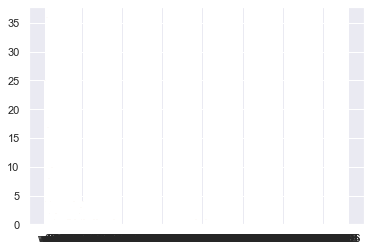

In [32]:
plt.bar(num_df.columns[:-2], num_df.loc[stream_list[0], num_df.columns[:-2]])
plt.bar(num_df.columns[:-2], num_df.loc[stream_list[1], num_df.columns[:-2]])
plt.show()

In [ ]:
for i in track(stream_list, description='painting'):
    plt.bar(num_df.columns[:-2], num_df.loc[i, num_df.columns[:-2]])
plt.plot()

Output()

In [ ]:
f = 0
l = 3
for i in stream_list[f:l]:
    plt.bar(num_df.columns[:-2], num_df.loc[i, num_df.columns[:-2]], label = i)
plt.plot()

In [ ]:

# All Splitedstart = 0
end = 4

fig, axs = plt.subplots(4,1, figsize=(16, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

for ax, i in zip(axs.ravel(), stream_list[start:end]):
    ax.bar(num_df.columns[:-2], num_df.loc[i, num_df.columns[:-2]], label = i)
    ax.set_title(str(i))

# <span style='background :yellow' > FIN </span>

# <span style='background :yellow' > Extraer Caracteristicas Manuales </span>

#### <span style='background :yellow' > Create Stream Class?? </span>

#### <span style='background :yellow' > ------------------------------------ </span>

In [ ]:
# Sacar las rachas
# Primero convertimos la lista en una lista de rachas

def streaks_to_list(s_l):
    streaks_l = []
    s_streak_l = []
    s_aux_l = []
    flag = 0
    
    for s in s_l:
        # Next Song
        for w in s:
            # First iteration over a song
            if (len(s_aux_l) == 0 and flag == 0):
                # Start Listening the Song
                if (w != 0):
                    s_aux_l.append(w)
                    flag = 1
                    
                # Start Without listening the Song
                elif(w == 0):
                    s_aux_l.append(w)
                    flag = 2
            
            # Already on a Streak
            else:
                # Continue Streak
                # Continue listening during next week
                if(w != 0 and flag == 1):
                    s_aux_l.append(w)
                    flag = 1
                    
                # Continue without listening during next week
                elif(w == 0 and flag == 2):
                    s_aux_l.append(w)
                    flag = 2
                    
                # Change
                # Change from Stop to listen
                elif(w != 0 and flag == 2):
                    s_streak_l.append(s_aux_l)
                    s_aux_l = []
                    s_aux_l.append(w)
                    flag = 1
                    
                # Change from listen to stop
                elif(w == 0 and flag == 1):
                    s_streak_l.append(s_aux_l)
                    s_aux_l = []
                    s_aux_l.append(w)
                    flag = 2
                
                
        # Song Last Iteration
        s_streak_l.append(s_aux_l)
        s_aux_l = []
        
        # Add song to streaks List
        streaks_l.append(s_streak_l)
        s_streak_l = []
        flag = 0
            
    return streaks_l

#### Check Rachas Work

In [ ]:
# Hacer comprobación todas valen 70
n_streak_stream = streaks_to_list(num_streamed)
print(len(n_streak_stream))
print(len(n_streak_stream[0]))
week_num = 0
for a in n_streak_stream[0]:
    week_num = week_num + len(a)
print(week_num)
print('\n')
print(len(n_streak_stream[3]))

In [ ]:
n_streak_stream[0]

#### Ini
-streak_length 

-positive_streaks 

-ix_positive_streaks

-negative_streaks 

-ix_negative_streaks

-start_or_end 

#### Stats
###### Max
-max_listened

-ix_max_listened

###### Lenght
-longest_streak

-ix_longest_streak

###### Biggest
-max_value_streak

-ix_max_value_streak

###### Empty Length
-longest_empty_streak

-ix_longest_empty_streak


In [ ]:
n_streak_stream[0][0][0]

In [ ]:
def define_streak(streaks_list):
    (streak_length, positive_streaks, ix_positive_streaks, 
     negative_streaks, ix_negative_streaks, start_or_end) = ini_count_streaks(streaks_list)
    
    (max_listened, ix_max_listened, longest_streak, value_longest_streak, ix_longest_streak, 
     max_value_streak, value_max_value_streak, ix_max_value_streak) = positive_stats_streaks(streaks_list, ix_positive_streaks)
    
    value_longest_empty_streak, ix_longest_empty_streak = negative_stats_streaks(streaks_list, ix_negative_streaks)
    
    return (streak_length, positive_streaks, ix_positive_streaks, 
            negative_streaks, ix_negative_streaks, start_or_end, 
            max_listened, ix_max_listened, longest_streak, value_longest_streak, ix_longest_streak, 
            max_value_streak, value_max_value_streak, ix_max_value_streak, 
            value_longest_empty_streak, ix_longest_empty_streak)
    
def ini_count_streaks(streaks_list):
    streak_length = len(streaks_list)
    positive_streaks = 0
    negative_streaks = 0
    ix_positive_streaks = []
    ix_negative_streaks = []
    start_or_end = ''
    
    i = 0
    for s in streaks_list:
        if i == 0 and s[0] == 0:
            start_or_end = 'end'
            negative_streaks = negative_streaks+1
            ix_negative_streaks.append(i)
            
        elif i == 0 and s[0] != 0:
            start_or_end = 'start'
            positive_streaks = positive_streaks+1
            ix_positive_streaks.append(i)
            
        elif s[0] == 0:
            negative_streaks = negative_streaks+1
            ix_negative_streaks.append(i)
            
        elif s[0] != 0:
            positive_streaks = positive_streaks+1
            ix_positive_streaks.append(i)
            
        i = i+1
    
    return streak_length, positive_streaks, ix_positive_streaks, negative_streaks, ix_negative_streaks, start_or_end



def positive_stats_streaks(streaks_list, ix_positive_streaks):
    max_listened = 0
    ix_max_listened = 0

    longest_streak = []
    value_longest_streak = 0
    ix_longest_streak = 0
    
    max_value_streak = []
    value_max_value_streak = 0
    ix_max_value_streak = 0

    i = 0
    for p in ix_positive_streaks:
        if(max_listened < max(streaks_list[p])):
            max_listened = max(streaks_list[p])
            ix_max_listened = i
            
        if(value_longest_streak < len(streaks_list[p])):
            value_longest_streak = len(streaks_list[p])
            longest_streak = streaks_list[p]
            ix_longest_streak = i
        
        if(value_max_value_streak < sum(streaks_list[p])):
            value_max_value_streak = sum(streaks_list[p])
            max_value_streak = streaks_list[p]
            ix_max_value_streak = i
        
        i = i+1        
    
    return (max_listened, ix_max_listened, longest_streak, value_longest_streak, ix_longest_streak, 
            max_value_streak, value_max_value_streak, ix_max_value_streak)
        
def negative_stats_streaks(streaks_list, ix_negative_streaks):
    value_longest_empty_streak = 0
    ix_longest_empty_streak = 0

    i = 0
    for n in ix_negative_streaks:
        if(value_longest_empty_streak < len(streaks_list[n])):
            value_longest_empty_streak = len(streaks_list[n])
            ix_longest_empty_streak = i
        
        i = i+1
    
    return value_longest_empty_streak, ix_longest_empty_streak

In [ ]:
# Ini Lists
streak_length = []
positive_streaks = []
ix_positive_streaks = []
negative_streaks = []
ix_negative_streaks = []
start_or_end = [] 

# Stats Lists
# Postive
max_listened = []
ix_max_listened = []

longest_streak = []
value_longest_streak = []
ix_longest_streak = []

max_value_streak = []
value_max_value_streak = []
ix_max_value_streak = []

# Negative
value_longest_empty_streak = []
ix_longest_empty_streak = []

aux = []

for s in track(n_streak_stream, description='Extracting Streaks Stats'):
    aux = define_streak(s)
    # ini - from 0 to 5 == 6
    # pos - from 6 to 13 == 8
    # neg - from 14 to 15 == 2
    # Total = 16 
    
    streak_length.append(aux[0])
    positive_streaks.append(aux[1])
    ix_positive_streaks.append(aux[2])
    negative_streaks.append(aux[3])
    ix_negative_streaks.append(aux[4])
    start_or_end.append(aux[5])

    max_listened.append(aux[6])
    ix_max_listened.append(aux[7])
    longest_streak.append(aux[8])
    value_longest_streak.append(aux[9])
    ix_longest_streak.append(aux[10])
    max_value_streak.append(aux[11])
    value_max_value_streak.append(aux[12])
    ix_max_value_streak.append(aux[13])
    
    value_longest_empty_streak.append(aux[14])
    ix_longest_empty_streak.append(aux[15])
    aux = []

In [ ]:
value_max_value_streak[3]

In [ ]:
longest_streak

### Flatten to make a histogram

In [ ]:
from collections import Counter

flat_longest_streak = [e for s in longest_streak for e in s]
flat_longest_streak

counts = Counter(flat_longest_streak)
print(counts)

plt.bar(counts.keys(), counts.values(), color='b')
plt.show


In [ ]:
sum(counts.values()) - (counts[1] + counts[2] + counts[3])

#### <span style='background :yellow' > Media de cuanto es la mayor racha de escucha </span>
#### <span style='background :yellow' > Media de cuanto es la primera racha de escucha </span>
#### <span style='background :yellow' > Canciones con valor solo una semana de escucha se pueden eliminar </span>
#### <span style='background :yellow' > Tratar Rachas negativas FIN (es decir no se han vuelto a escuchar hasta la fecha) </span>
#### <span style='background :yellow' > Tratar Rachas negativas START (aun no se han descubierto) </span>

### Outlayers

#### Z-Score Vs IQR -- We making IQR but bibliograpghy pls 

In [ ]:
def detect_outliers_iqr(data, low_p = 2.5, high_p = 97.5):
    q1, q3 = np.percentile(data, [low_p, high_p])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))

In [ ]:
outlier_indices = detect_outliers_iqr(flat_longest_streak, 25, 75)
print(outlier_indices)
print(len(outlier_indices[0]))

In [ ]:
outlier_indices = detect_outliers_iqr(flat_longest_streak)
print(outlier_indices)
print(len(outlier_indices[0]))

In [ ]:
outs_p = []
for i in outlier_indices[0]:
    outs_p.append(flat_longest_streak[i])

In [ ]:
outs_p_count = Counter(outs_p)
print(outs_p_count)

#### Z-Score

In [ ]:
def detect_outliers_z_score(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(y - mean) / std for y in data]
    return np.where(np.abs(z_scores) > threshold)

In [ ]:
outlier_indices = detect_outliers_z_score(flat_longest_streak)
print(len(outlier_indices[0]))

In [ ]:
outs_z = []
for i in outlier_indices[0]:
    outs_z.append(flat_longest_streak[i])

In [ ]:
outs_z_count = Counter(outs_z)
print(outs_z_count)

# Resulting Plot Removing Outlayers and 1s - even 2s??

#### We want to train with all information possible, like 1, 2 and 3 are all the 25-75 percentil, the best is to remove them 3

In [ ]:
'''p75 = np.percentile(numbers, 75)
p75

per75 = Counter([x for x in numbers if x >= p75])
print(per75)'''

### Full Remove Most repeated

In [ ]:
#longest_streak
#flat_longest_streak
#counts

In [ ]:
# Create aux dictionary
full_remove = counts.copy()

# Remove 75p
full_remove.pop(1)
full_remove.pop(2)
full_remove.pop(3)

# Remove outlayers
for i in outs_p_count:
    full_remove.pop(i)

In [ ]:
print(full_remove)

plt.bar(full_remove.keys(), full_remove.values(), color='b')
plt.show

In [ ]:
sum(full_remove.values())

In [ ]:
flag_75 = 0
flag_0 = 0

full_remove_list = []

for f in flat_longest_streak:
    # 75% of data Condition
    for i in [1,2,3]:
        if f == i:
            flag_75 = 1
            
    # Outlayer Condition
    for outlayer in outs_p_count:
        if f == outlayer:
            flag_0 = 1
            
    if flag_75 == 0 and flag_0 == 0:
        full_remove_list.append(f)
        
    flag_75 = 0
    flag_0 = 0

In [ ]:
print(len(full_remove_list))
magic_number = round(np.mean(full_remove_list))
magic_number

# <span style='background :yellow' > Try different Strategies to compare how the predictions are done </span>

This proces will all data, only removing +75% percentil, excludes the highest streaks, and the ending result is = 1